In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re
from numpy.random import seed
import nltk.stem
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


ru_stemmer = nltk.stem.SnowballStemmer('russian')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([ru_stemmer.stem(w) for w in analyzer(doc)])



In [2]:
%%time
data_start=pd.read_pickle('data/WikiData_dat_5.pkl')
topic=[]
for row in data_start['cat'].tolist():
    if "спорт" in row:
        topic.append("sport")
    else:
        topic.append("other")
print (len(topic))
data_start['topic']=topic
data_bi=data_start[['title', 'cat', 'text2', 'noun', 'topic']][:3000]
data_test=data_start[['title', 'cat', 'text2', 'noun', 'topic']][3000:4000]
d_sport = (data_bi['topic']==u'sport')
data=data_bi.loc[d_sport]
print (len(data), len(data_test))


10748
117 1000
Wall time: 1.02 s


In [3]:
dfTimeUniqCat=pd.unique(data.topic.ravel())
print (len(dfTimeUniqCat))
category = data['topic'].tolist()
category = [str(i) for i in category]
#category = list(map(str, category))
content = data['title'].tolist()
stop_words = ['и']
content  = [str(x) for x in content]
for x in category:
    if not isinstance(x, str):
        print (x)


1


In [4]:
%%time
vectorizerContent = StemmedCountVectorizer (min_df=1, stop_words=stop_words, lowercase=True, analyzer="word")
vectorizerCategory = CountVectorizer (min_df=1)

X = vectorizerContent.fit_transform(content)
Xcat = vectorizerCategory.fit_transform(category)
xx = X.toarray().transpose()
xxcat = Xcat.toarray().transpose()

selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())


Wall time: 69.1 ms


In [5]:
class OcTm (object):
    def __init__(self,  eta=1.0):
        self.eta=eta
        
    def fit(self, X, y):
        i = 0
        self.Pwt = 0
        for xC in y:
            self.Pwt += np.array(xC.toarray())*np.array(X[i].toarray().transpose())
            i += 1
        i1 = 0
        self.Theta = np.arange(self.Pwt.size, dtype=float).reshape(self.Pwt.sum(axis=1).size, self.Pwt[0].size)
        for el4 in self.Pwt.sum(axis=1):
            i2 = 0
            for el1 in self.Pwt[i1]:
                self.Theta[i1][i2]=float(el1)/self.Pwt[i1].sum()
                i2 += 1
            i1 += 1
        return self
    
    def predict(self, query):
        predictMatrixW = []
        for w in query.split(" "):
            newWord = vectorizerContent.transform([w]).toarray()
            value_True=1.0-self.eta
            value_False=self.eta
            el_data= {}
            if newWord.sum()==0:
                el_data[selected_feature_names_Cat[0]] = value_True
                el_data['other'] = value_False
                predictMatrixW.append(dict(el_data))
            else:
                j=0
                for inNew in np.nditer(newWord):
                    if inNew > 0:
                        cVal=self.Theta[j][0]
                        el_data[selected_feature_names_Cat[0]] = cVal
                        el_data['other'] = 1.0-cVal
                        predictMatrixW.append(dict(el_data))
                    j+=1
        dfMW = DataFrame(predictMatrixW)
        dfSumMW=dfMW.sum()
        i =0
        dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
        for el in dfSumMW.T.iteritems():
            i += 1
            if i < 2:
                return (el[0], el[1]/dfSumMW.sum())



In [6]:
%%time
penalty=[0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.5, 0.4]
score_p=[]
for v in penalty:
    i = 0
    outputpredict = []
    ot=OcTm(eta=v)
    ot.fit(X, Xcat)
    for query in data_test['title']:
        out=ot.predict(query)
        outputpredict.append(out[0])
        i+=1
    score = metrics.accuracy_score(data_test.topic.tolist(), outputpredict)
    score_p.append(score)
    print("accuracy:   %0.3f" % score)
    confmat=confusion_matrix(data_test.topic.tolist(), outputpredict)
    print (confmat)

    

accuracy:   0.903
[[887  82]
 [ 15  16]]
accuracy:   0.903
[[887  82]
 [ 15  16]]
accuracy:   0.895
[[877  92]
 [ 13  18]]
accuracy:   0.877
[[859 110]
 [ 13  18]]
accuracy:   0.841
[[821 148]
 [ 11  20]]
accuracy:   0.714
[[690 279]
 [  7  24]]
accuracy:   0.031
[[  0 969]
 [  0  31]]
accuracy:   0.031
[[  0 969]
 [  0  31]]
Wall time: 27.3 s


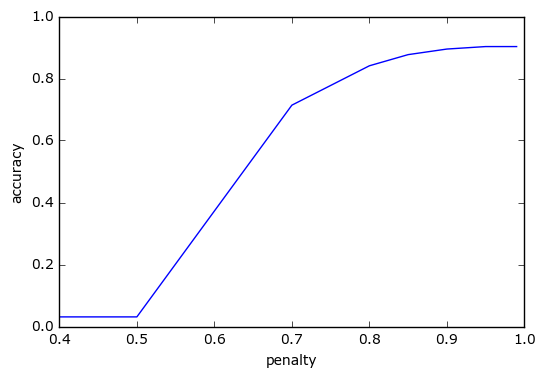

In [8]:
plt.figure()
plt.plot(penalty, score_p)
plt.ylabel('accuracy')
plt.xlabel('penalty')
plt.savefig('data/OC-TM.png')
plt.show()